# A movie Recommendation System Using MovieLens Data

**Project Overview**

This project focuses on analyzing movie ratings from the MovieLens dataset to provide tailored movie recommendations. It combines collaborative filtering and content-based filtering, to identify the top 5 movies most suited to a user's interests. This dual approach enhances the recommendation accuracy by integrating both user-driven insights and movie-specific characteristics, creating a robust, personalized viewing experience.

**Business Understanding**

In today’s digital age, online streaming platforms such as Netflix, Showmax,HBO,provide a vast library of movies across various genres, which users can stream on devices like smartphones, tablets, smart TVs, and computers. These platforms generate vast amounts of data on user interactions, including viewing habits, preferences, and ratings. However, the challenge lies in leveraging this data to enhance user engagement by providing personalized movie recommendations that align with individual tastes. 

Personalization has a proven impact on engagement; for example, [75% of what people watch on Netflix](https://litslink.com/blog/all-about-netflix-artificial-intelligence-the-truth-behind-personalized-content) comes from its personalized recommendations, highlighting the importance of robust recommendation algorithms in guiding users toward their next favorite show or movie. The goal of this project is to improve user satisfaction and retention by suggesting the top 5 movies a user is likely to enjoy, utilizing a blend of collaborative and content-based filtering.

**Problem Statement**

With the increasing volume of movies available on streaming platforms, users often experience choice overload, making it difficult to discover content that matches their preferences. This reduces user satisfaction and engagement, negatively impacting retention rates for content providers. The challenge is to develop a personalized recommendation system that can accurately predict and suggest movies tailored to individual users' tastes. 

**Objectives**

1. To identify the top 10 most popular genres based on user ratings.
2. To identify if there is a relationship between movie genres and ratings.
3. To examine user-generated tags to identify popular keywords associated with genres and movie themes.
4. To build a recommendation system that suggests the top 5 rated movies to a user.

**Success Metrics**

**Data Understanding**

The [dataset](https://grouplens.org/datasets/movielens/latest/) for the analysis is from the GroupLens research lab at the University of Minnesota. It entails 100,000 movie ratings. It entails different csv files



In [45]:
#Importing the necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import f_oneway
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
from surprise import SVD,Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.knns import KNNBasic
import warnings
warnings.filterwarnings("ignore")
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading  Data

In [2]:
#loading the csv files
from Functions import load_data

#Defining the csv file paths 
movie_file_path = "Data/movies.csv"
rating_file_path= "Data/ratings.csv"
tags_file_path= "Data/tags.csv"

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#Importing function for loading data
from Functions import explore_data

#Loading and inspecting the movie csv file
movie_df = pd.read_csv(movie_file_path)  
explore_data(movie_df)

displaying the first 5 rows 
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

Shape of the dataset:  (9742, 3) 

Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memo

In [4]:
#Loading and inspecting the movie ratings csv file
rating_df = pd.read_csv(rating_file_path)  
explore_data(rating_df)

displaying the first 5 rows 
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931 

Shape of the dataset:  (100836, 4) 

Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Statistical summary:
               userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+0

In [5]:
#Loading and inspecting movie tags csv
tags_df = pd.read_csv(tags_file_path)  
explore_data(tags_df)

displaying the first 5 rows 
    userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200 

Shape of the dataset:  (3683, 4) 

Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Statistical summary:
             userId        movieId     timestamp
count  3683.000000    3683.000000  3.683000e+03
mean    431.149335   27252.013576  1.320032e+09
std     158.472553   43490.558803  1.721025e+08
min       2.000000    

## Data Cleaning

This section will involve checking the following about the dataset.
- Accuracy
- Validity
- Completeness
- Uniformity

**1. Accuracy**

**Checking for duplicates**

In [6]:
#Check for duplicates
from Functions import check_and_remove_duplicates
# Checking and removing duplicates in movies dataset
movie_df = check_and_remove_duplicates(movie_df)

# Checking and removing duplicates in ratings dataset
rating_df = check_and_remove_duplicates(rating_df)

# Checking and removing duplicates in tags dataset
tags_df = check_and_remove_duplicates(tags_df)


Number of duplicate rows: 0
No duplicates found.
Number of duplicate rows: 0
No duplicates found.
Number of duplicate rows: 0
No duplicates found.


**Interpretation**

After running the check on all three datasets (movies, ratings, and tags), we confirm that no duplicate rows were found in any of the datasets. Therefore, the data is clean in this regard and requires no further action to remove duplicates, ensuring the integrity of the subsequent analysis.

**Checking for outliers**

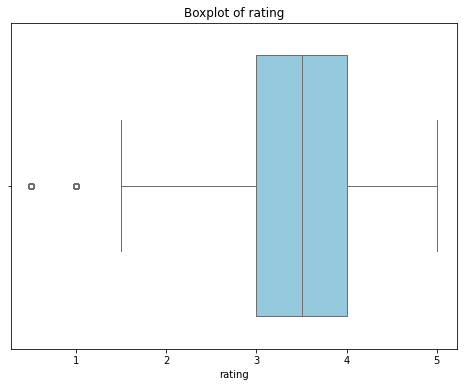

In [7]:
#Checking for outliers in the 'rating' column of the ratings dataset
from Functions import visualize_outliers_with_boxplot
visualize_outliers_with_boxplot(rating_df, 'rating')

**Interpretation**

The boxplot of the rating column shows that most ratings fall between 3.0 and 4.5, indicating a general preference for higher-rated movies, with a few low outliers reflecting strong dislikes.These outliers are retained because they provide meaningful insights into user behavior, particularly reflecting strong negative opinions about certain movies. Low ratings are critical for understanding user dislikes, which is essential for preventing the recommendation system from suggesting unsuitable movies. By maintaining these outliers, the recommendation system can better capture the diversity of user sentiments, leading to more robust and personalized recommendations that accurately represent the full spectrum of user preferences.


**2.Validity**

In [8]:
#Check for consistency in datatypes
#Converting Timestamp into DATE format

#Converting the timestamp into date format
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'])
tags_df['timestamp']= pd.to_datetime(tags_df['timestamp'])  


#Extracting the date

rating_df['timestamp'] = rating_df['timestamp'].dt.date
tags_df['timestamp']=tags_df['timestamp'].dt.date
tags_df['timestamp']
rating_df['timestamp']

0         1970-01-01
1         1970-01-01
2         1970-01-01
3         1970-01-01
4         1970-01-01
             ...    
100831    1970-01-01
100832    1970-01-01
100833    1970-01-01
100834    1970-01-01
100835    1970-01-01
Name: timestamp, Length: 100836, dtype: object

In [9]:
#Checking for unique values in the date column for the rating csv
rating_df['timestamp'].value_counts()

1970-01-01    100836
Name: timestamp, dtype: int64

In [10]:
#Checking for unique values in the date column for the tags csv
tags_df['timestamp'].value_counts()

1970-01-01    3683
Name: timestamp, dtype: int64

Since the timestamp column only indicates the time when users rated a movie and all values fall within the same year (1970), it does not add valuable information to our analysis. Therefore, we will drop it from the dataset to streamline our data and focus on more relevant features.

In [11]:
#Drop irrelevant columns
#Dropping the timestamp column
rating_df=rating_df.drop('timestamp',axis=1)
tags_df=tags_df.drop('timestamp',axis=1)

In [12]:
#Confirm the column names after dropping timestamp
rating_df.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

In [13]:
#Confirm the column names after dropping the timestamp column
tags_df.columns

Index(['userId', 'movieId', 'tag'], dtype='object')

In [14]:
#Checking for column names
""" The column names are consistent in naming for all files. They are also all in lower case."""

' The column names are consistent in naming for all files. They are also all in lower case.'

**3.Completeness**

In [15]:
#Impute missing values
"""
The data presented not to have any missing values, so no imputation was done.

"""

'\nThe data presented not to have any missing values, so no imputation was done.\n\n'

**4. Consistency/Uniformity**

In [16]:
#Column names capitalization
"""
All the columns displayed consistency in their naming and were all in lower case.
"""

'\nAll the columns displayed consistency in their naming and were all in lower case.\n'

In [17]:
#Checking if ratings lie within the same range
"""
All the movie ratings were in the same range, ranging from 0.5 to 5 star rating, with no missing value as well.
"""

'\nAll the movie ratings were in the same range, ranging from 0.5 to 5 star rating, with no missing value as well.\n'

In [18]:
# Splitting the movie titles from the years
movie_df["Release_year"] = movie_df["title"].apply( lambda x: x[-5:-1] if x[-5:-1].isdigit() else "0000")
movie_df["Release_year"] = movie_df["Release_year"].astype("int64")
movie_df["Release_year"]

0       1995
1       1995
2       1995
3       1995
4       1995
        ... 
9737    2017
9738    2017
9739    2017
9740    2018
9741    1991
Name: Release_year, Length: 9742, dtype: int64

In [19]:
movie_df["genres"].unique()[:40]

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance',
       'Comedy|Drama|Romance', 'Comedy', 'Action|Crime|Thriller',
       'Adventure|Children', 'Action', 'Action|Adventure|Thriller',
       'Comedy|Horror', 'Adventure|Animation|Children', 'Drama',
       'Action|Adventure|Romance', 'Crime|Drama', 'Drama|Romance',
       'Action|Comedy|Crime|Drama|Thriller', 'Comedy|Crime|Thriller',
       'Crime|Drama|Horror|Mystery|Thriller', 'Drama|Sci-Fi',
       'Children|Drama', 'Adventure|Drama|Fantasy|Mystery|Sci-Fi',
       'Mystery|Sci-Fi|Thriller', 'Children|Comedy', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure|Fantasy',
       'Comedy|Drama|Thriller', 'Mystery|Thriller',
       'Animation|Children|Drama|Musical|Romance',
       'Crime|Mystery|Thriller', 'Adventure|Drama', 'Drama|Thriller',
       'Comedy|Crime', 'Action|Sci-Fi|Thriller',
       'Action|Comedy|Horror|Thriller', 'Comedy|Drama', 'Documentary',
       'Ac

Most movies seem to be a **combination of multiple genres** hence why there are so so many unique combinations.

Let's seperate these combinations into individual genres and get more granular data

In [20]:
# seperate the combinations into individual genres by removing the "," seperators
movie_df['genres'] = movie_df['genres'].str.split('|')

# create a new Exploded dataframe with the list of genres into individual rows
movie_df= movie_df.explode('genres').reset_index(drop=True)


movie_df.head()

,movieId,title,genres,Release_year
0,1,Toy Story (1995),Adventure,1995
1,1,Toy Story (1995),Animation,1995
2,1,Toy Story (1995),Children,1995
3,1,Toy Story (1995),Comedy,1995
4,1,Toy Story (1995),Fantasy,1995


The genres column is now made up of lists of individual genres.

**Merging the movie_df with rating_df** 

In [21]:
merged_df=pd.merge(rating_df,movie_df, on='movieId')
merged_df

,userId,movieId,rating,title,genres,Release_year
0,1,1,4.0,Toy Story (1995),Adventure,1995
1,1,1,4.0,Toy Story (1995),Animation,1995
2,1,1,4.0,Toy Story (1995),Children,1995
3,1,1,4.0,Toy Story (1995),Comedy,1995
4,1,1,4.0,Toy Story (1995),Fantasy,1995
...,...,...,...,...,...,...
274475,610,160836,3.0,Hazard (2005),Drama,2005
274476,610,160836,3.0,Hazard (2005),Thriller,2005
274477,610,163937,3.5,Blair Witch (2016),Horror,2016
274478,610,163937,3.5,Blair Witch (2016),Thriller,2016


In [22]:
explore_data(merged_df)

displaying the first 5 rows 
    userId  movieId  rating             title     genres  Release_year
0       1        1     4.0  Toy Story (1995)  Adventure          1995
1       1        1     4.0  Toy Story (1995)  Animation          1995
2       1        1     4.0  Toy Story (1995)   Children          1995
3       1        1     4.0  Toy Story (1995)     Comedy          1995
4       1        1     4.0  Toy Story (1995)    Fantasy          1995 

Shape of the dataset:  (274480, 6) 

Dataset info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274480 entries, 0 to 274479
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   userId        274480 non-null  int64  
 1   movieId       274480 non-null  int64  
 2   rating        274480 non-null  float64
 3   title         274480 non-null  object 
 4   genres        274480 non-null  object 
 5   Release_year  274480 non-null  int64  
dtypes: float64(1), int64(3), obje

**Checking for the Distribution of the data**

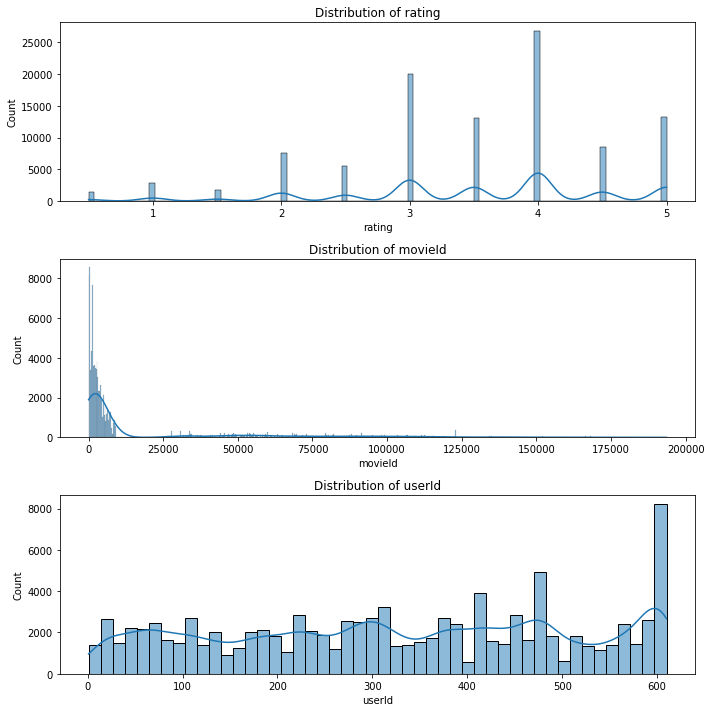

In [23]:
numerical_cols_df = merged_df[["rating", "movieId", "userId"]]

# Create 4x4 grid of subplots
fig, axes = plt.subplots(3, figsize=(10,10))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Looping through each column and plotting in the respective subplot
for i, col in enumerate(numerical_cols_df):
    sns.histplot(x=rating_df[col], ax=axes[i], kde=True)  
    axes[i].set_title(f'Distribution of {col}')  

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

**Interpretation**

The analysis reveals that movie ratings are generally skewed towards higher values, with most users giving positive feedback. Although there are a few instances of very low ratings, these are exceptions rather than the norm. 

Regarding movie IDs, the distribution shows a heavy right-skew, indicating that while many movies receive few ratings, a smaller set of movies attracts a large number of ratings. 

Lastly, the distribution of user IDs is relatively uniform, suggesting that a moderate number of users contribute a similar amount of ratings, although some users may rate more frequently than others.

To address the skewness in the data, we will apply MinMax scaling during the modeling phase.Since we decided to retain the outliers in our analysis, MinMax scaling will normalize the data to a fixed range while preserving the relative relationships between the features, including the outliers.

## Exploratory Data Analysis

**1. To identify the top 10 most popular genres based on the number of user ratings.**


In [24]:
# Group by genres and calculate the total number of ratings
genre_ratings = merged_df.groupby('genres').agg(
    Rating_Count=('rating', 'count')
).reset_index()

# Sort genres by the number of ratings and select the top 10
top_genres = genre_ratings.sort_values(by='Rating_Count', ascending=False).head(10)

# Display the top 10 genres
print(top_genres)

       genres  Rating_Count
8       Drama         41928
5      Comedy         39053
1      Action         30635
17   Thriller         26452
2   Adventure         24161
15    Romance         18124
16     Sci-Fi         17243
6       Crime         16681
9     Fantasy         11834
4    Children          9208


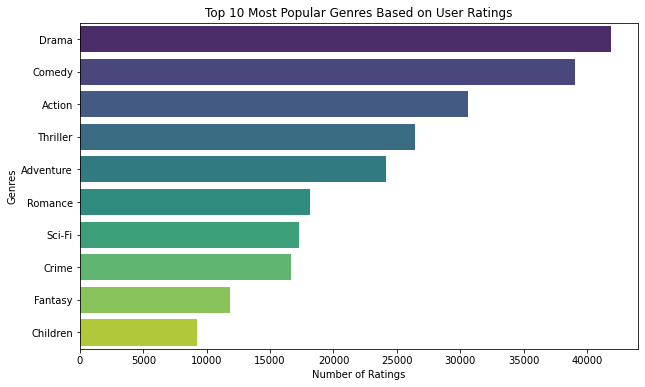

In [25]:
# Plotting the top 10 genres
plt.figure(figsize=(10, 6))
sns.barplot(x='Rating_Count', y='genres', data=top_genres, palette='viridis')
plt.title('Top 10 Most Popular Genres Based on User Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Genres')
plt.show();

**Interpretation**

The graph displays the top 10 most-rated genres, with Drama having the highest number of user ratings, followed by Comedy and Action. This sheds light on the kind of genres which were highly watched by different users.

**2. To Identify the top 10 Genres with the highest ratings**

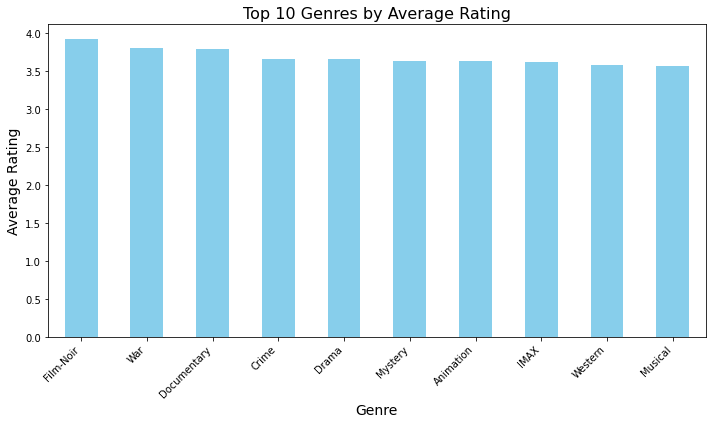

In [26]:
# Group by genre and calculate the average rating for each genre
top_10_genres_avg_rating =merged_df.groupby('genres')['rating'].mean().sort_values(ascending=False)

# Select the top 10 genres
top_10_genres = top_10_genres_avg_rating.head(10)

# Plotting the top 10 genres by average rating
plt.figure(figsize=(10,6))
top_10_genres.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title('Top 10 Genres by Average Rating', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

**Interpretation**

The graph presents the genres which were highly rated, with Film-Noir presenting to have the highest rating, followed by war then documentary.

**3. To Identify the distribution of movie ratings per user**

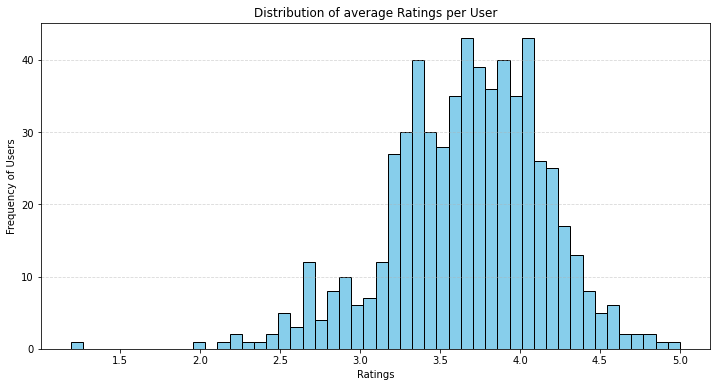

In [27]:
# Display the average ratings per user
ratings_per_user = merged_df.groupby('userId')['rating'].mean()

# Create a histogram of ratings per user
plt.figure(figsize=(12, 6))
ratings_per_user.plot(kind='hist', bins=50, color='skyblue', edgecolor='black') 

# Customize the plot
plt.title('Distribution of average Ratings per User')
plt.xlabel('Ratings')
plt.ylabel('Frequency of Users')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show the plot
plt.show()

**Interpretation**

The distribution indicates that the majority of movie ratings fall within the 2 to 4.5 star range, suggesting that most users tend to rate movies positively. However, the presence of a few low ratings below 2 stars highlights that there are still some users who express strong dissatisfaction, potentially due to varying expectations or specific negative experiences with certain films.

**4.To identify the trend of movies' production by decade**

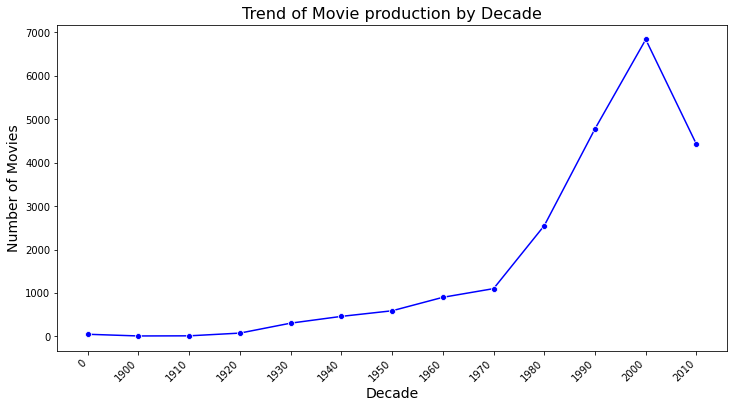

In [28]:
# Calculate the number of movies by decade
movie_df['Decade'] = (movie_df['Release_year'] // 10) * 10
movies_by_decade = movie_df.groupby('Decade').size()

# Extract decades and counts
decades = movies_by_decade.index
counts = movies_by_decade.values

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=decades.astype(str), y=counts, marker='o', color='blue') 

# Add labels and title
plt.title('Trend of Movie production by Decade', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14) 

# Customize x-axis ticks
plt.xticks(rotation=45, ha='right') 

# Show the plot
plt.show()

**Interpretation**

The graph presents that movie production remained slow in the 1900s, but saw a significant increase starting in the 1970s. This upward trajectory can be attributed to technological advancements, higher demand for films, and greater investment in the film industry. However, from the 2000s onward, production is seen to fluctuate, likely due to changes in market dynamics, including the rise of digital streaming platforms, evolving consumer preferences, and increased competition within the entertainment industry.

**5. To examine the number of ratings per movie**

In [29]:
# Set a threshold to focus on movies with a reasonable number of ratings
ratings_threshold = 50  

# Filter ratings per movie to focus on movies with less than the threshold
filtered_ratings = ratings_per_movie[ratings_per_movie <= ratings_threshold]

# Plot the histogram for the filtered data
plt.figure(figsize=(12, 6))
sns.histplot(filtered_ratings, bins=30, kde=False, color='skyblue')
plt.title('Distribution of Number of Ratings Per Movie (Filtered)', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=14)
plt.ylabel('Count of Movies', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

NameError: name 'ratings_per_movie' is not defined

**6. To identify if there is a relationship between movie genres and ratings.**

Null Hypothesis (H₀): There is no relationship between movie genres and ratings.

Alternative Hypothesis (H₁): There is a significant relationship between movie genres and ratings.

In [ ]:
genre_ratings = merged_df.groupby('genres')['rating'].apply(list)

# Perform one-way ANOVA (if assumptions are satisfied)
anova_result = f_oneway(*genre_ratings)
print('ANOVA result:', anova_result)

**Interpretation**

F-statistic: 176.87 suggests a large difference between the mean ratings of the different genres.

Since the p-value is less than 0.05, we reject the null hypothesis. This means that there is a significant difference between the average ratings of at least some of the movie genres.

**Examining rating distributions by genre**

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='genres', y='rating', data=merged_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Distribution of Ratings by Genre')
plt.show()

**Interpretation**

Since the hypothesis testing highlighted that there is a significant difference in ratings by genre, the above box plots displays how these ratings vary by genre. With some genre ratings ranging from 3-4 star ratings , others 2.5 to 4.5 star ratings while others 3.5 to 4.5 star rating.This disparity reveals that, certain genres tend to receive more consistent ratings, while others experience greater variability, possibly reflecting differing audience expectations, preferences, or subjective opinions about the films within each genre.

**7. To examine user-generated tags to identify popular keywords associated with movie themes.**

In [ ]:
# Initialize lemmatizer and stop words list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# converting the tags to lowercase and removing non-alphabetic characters
tags_df['tag'] = tags_df['tag'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# Tokenize the tags, remove stop words, and apply lemmatization
tags_df['processed_tag'] = tags_df['tag'].apply(lambda x: [
    lemmatizer.lemmatize(word) for word in word_tokenize(x) if word not in stop_words
])

# Flatten the list of lists to get all words in one list
all_words = [word for tag in tags_df['processed_tag'] for word in tag]

# Get word frequency
word_counts = pd.Series(all_words).value_counts().reset_index()
word_counts.columns = ['word', 'count']

# Display the top 10 most frequent words
top_10_words = word_counts.head(10)

# Plotting the top 10 words
plt.figure(figsize=(10, 6))
plt.bar(top_10_words['word'], top_10_words['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words in Movie Tags')
plt.show()

# Print the top 10 words
print(top_10_words)

**Interpretation**

The most frequent words highlights on users preferences.

- Netflix being on the top would highly imply that most movies were watched from netflix.

- Queue would indicate that most users usually tag or add movies to their watchlist.

- Word like Ending would suggest that most users are particularly focused on the conclusion of movies implying that a movie's ending is a key feature for most films.

- The word Movie appears commonly to reflect that most users tag films as 'movies' compared to the 'series' term. This implies that movie is frequently watched compared to series.

- Other words such as funny, dark and comedy highlights on the frequently watched themes, which would be key in offering a movie recommendation.

- Sci-Fi, space and Atmospheric implies that there is also a good chunk of users who are drawn to watching movies related to science fiction genres or movies with strong mood setting.

## Modeling

**8. To build a recommendation system that suggests the top 5 rated movies to a user.**

In [ ]:
#collaborative filtering
#-memorybased-knn
#model-based-svd-tuning

#1. Identify the users/items-user based collaborative filtering/Memory(use the entire dataset)
#2. Dealing sparsity
#Matrix Factorization using SVD
#3. Dealing with coldstart problem-content based filtering
#4. Scaling the data-apply pipelines
#5. Building the model-KNN,-specify the similarity metric(cosine,pearson,Jaccard)
#6.SVD-tune

#Data preprocessing
#Scaling data
#Encoding categorical values
#Deal with sparsity i.e Remove users or items with too few interactions.
#Apply dimensionality reduction methods or matrix factorization (e.g., SVD)
# Address coldstart problem-
#Convert the data into a format suitable for the model.


**Data Preprocessing**

In [35]:
#Scaling our data
scaler=StandardScaler()

#fit scaled ratings
rating_df['scaled_rating']=scaler.fit_transform(rating_df[['rating']])

We applied StandardScaler to our data to handle outliers in the rating column, as we chose to work with them. This approach is particularly helpful given that the algorithms used in our model, KNN and SVD, are sensitive to outliers.The approach will reduce the effect of outliers to the model.

In [36]:
#Transforming data to be compatible with surprise library
reader = Reader()
data = Dataset.load_from_df(rating_df[['userId', 'movieId', 'scaled_rating']],reader)

In [37]:
#Check for the number of users and items in our dataset
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


Our data presents to have fewer users compared to the number of movies, which creates a sparse matrix. The below code will inspect the level of sparsity for our data. Then follow up to apply either collaborative or content-based filtering based on the level of our data sparsity.

In [47]:
#cheking for level of sparsity for our data
def create_X(df):
    #Identify the unique users and movies in our data
    num_users = df["userId"].nunique()
    num_movies = df["movieId"].nunique()
    
    #Create mappings for user ids and movie ids 
    user_mapper = {user_id: i for i, user_id in enumerate(df["userId"].unique())}
    movie_mapper = {movie_id: i for i, movie_id in enumerate(df["movieId"].unique())}
    
    #Inverse mappings for users and movies IDs

    user_inv_mapper = {v: k for k, v in user_mapper.items()}
    movie_inv_mapper = {v: k for k, v in movie_mapper.items()}
    
    #Map users and Movie IDs to indices

    user_idx = df["userId"].map(user_mapper)
    movie_idx = df["movieId"].map(movie_mapper)
    
    #Creates sparse matrix
    X = csr_matrix((df["rating"].values, (movie_idx, user_idx)), shape=(num_movies, num_users))
    
    #Calculating sparsity for our data

    sparsity = 1 - (X.nnz / (X.shape[0] * X.shape[1]))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper, sparsity

#Display sparsity value for our data
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper, sparsity = create_X(rating_df)
sparsity_value = 100 - (sparsity * 100) 
print(f"Matrix sparsity: {sparsity_value:.2f}%")

Matrix sparsity: 1.70%


Our sparsity value is above 1 meaning that our data is highly sparsed, which is typical in recommendation systems, as users generally rate only a small subset of movies they’ve watched. Therefore, to address this, we will consider collaborative filtering in building our recommendation system.This is because collaborative filtering leverages patterns in user-item interactions, even when most interactions are missing, by predicting missing ratings based on similarities between users or items.

**Determining the best model**

In [42]:
#Performing Gridsearch for SVD Model
param_grid = {
    'n_factors': [5, 10, 15],        # Number of latent factors
    'reg_all': [0.02, 0.05, 0.1],      # Regularization term
    'lr_all': [0.002, 0.005, 0.01],    # Learning rate
    'n_epochs': [20, 30, 50]           # Number of epochs
}

# Initialize the GridSearchCV with the SVD algorithm
gs = GridSearchCV(SVD, param_grid,cv=5, n_jobs=-1)
# Fit the GridSearchCV
gs.fit(data)

# Get the best parameters and their corresponding score
print("Best RMSE score:", gs.best_score)
print("Best parameters:", gs.best_params)

Best RMSE score: {'rmse': 1.4142092897119058, 'mae': 1.1136267581163295}
Best parameters: {'rmse': {'n_factors': 15, 'reg_all': 0.1, 'lr_all': 0.002, 'n_epochs': 20}, 'mae': {'n_factors': 15, 'reg_all': 0.05, 'lr_all': 0.01, 'n_epochs': 30}}


The gridsearch results presents the best RMSE score to be 1.414 which was achieved with 15 latent factors, a regularization term of 0.1, a learning rate of 0.002, and 20 epochs, while the best MAE score of 1.11 came from 15 latent factors, a regularization term of 0.05, a learning rate of 0.01, and 30 epochs.

In [44]:
#Cross Validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([1.42202633, 1.41448053, 1.40319021, 1.4266767 , 1.41045975]))
('test_mae', array([1.12103227, 1.11398429, 1.10712531, 1.12598497, 1.11097052]))
('fit_time', (1.8566372394561768, 1.8534140586853027, 1.840834617614746, 1.7900831699371338, 1.6897900104522705))
('test_time', (2.3487489223480225, 2.3278086185455322, 2.3513994216918945, 2.347350597381592, 2.294785976409912))
-----------------------
1.4153667037116728


The test RMSE values range from 1.40 to 1.43, indicating consistent performance, while the test MAE values range from 1.11 to 1.12, reflecting a small margin of error. The model's fit time averages around 1.83 seconds, and the test time is approximately 2.33 seconds, showing relatively quick computation. The overall mean RMSE is 1.415, suggesting stable performance across different folds

In [45]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
('test_rmse', array([1.41173533, 1.41257758, 1.42332523, 1.41664354, 1.41696095]))
('test_mae', array([1.11516534, 1.11431538, 1.11918899, 1.11318814, 1.11688968]))
('fit_time', (1.3015086650848389, 1.3073387145996094, 1.414597749710083, 1.2291531562805176, 1.2883191108703613))
('test_time', (2.1251564025878906, 2.5132839679718018, 2.3295226097106934, 2.1620290279388428, 2.1268370151519775))


1.4162485270735659

The test RMSE values range from 1.41 to 1.42, indicating consistent performance, while the test MAE values range from 1.11 to 1.12, reflecting minimal prediction error. The model's fit time averages around 1.30 seconds, and the test time is approximately 2.31 seconds, suggesting efficient computation. The overall mean RMSE is 1.416, showing stable and reliable performance across different folds.

**Overall Interpretation for the models**

Comparing the Root Mean Squared Error(RMSE) for the above models, SVD presents to have the least rmse,signaling that it makes the most accurate predictions about users' ratings. RMSE measures the square root of the average squared differences between the predicted and actual ratings, so a lower value indicates that the model's predictions are closer to the true ratings. This suggests that SVD is better at capturing underlying patterns and preferences in the data compared to other models, making it the most suitable choice for building our recommendation system. Additionally, SVD works by breaking down the sparse matrix of user-item interactions into smaller, dense matrices (latent factors) that capture these hidden patterns, helping to predict missing ratings.

**Making Recommendations using Collaborative filtering**

In [52]:
#fit and predicting the model
svd = SVD(n_factors= 15, reg_all= 0.1, lr_all= 0.002,n_epochs= 20)
svd.fit(dataset)

svd.predict(5,7)

Prediction(uid=5, iid=7, r_ui=None, est=1, details={'was_impossible': False})

In [ ]:

#Checking for cold-start problems(collaborative filtering)

## Content-Based Filtering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

#Use genres instead of tags
# Sample DataFrame: Movie titles and their tags
movies_df = pd.DataFrame({
    'movieId': [1, 2, 3, 4],
    'title': ['Movie A', 'Movie B', 'Movie C', 'Movie D'],
    'tags': ['action adventure', 'comedy romance', 'action thriller', 'romance drama']
})

# Vectorize the tags using TF-IDF (Term Frequency - Inverse Document Frequency)
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['tags'])

# Calculate the cosine similarity between all movie pairs
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend movies based on similarity score
def recommend_movies(movie_title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = movies_df.index[movies_df['title'] == movie_title].tolist()[0]
    
    # Get pairwise similarity scores for that movie with all other movies
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the indices of the top 3 most similar movies
    sim_scores = sim_scores[1:4]  # Skip the first movie as it's the same as the input movie
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 3 most similar movies
    return movies_df['title'].iloc[movie_indices]

# Example: Recommend movies similar to 'Movie A'
recommended_movies = recommend_movies('Movie A')
print(recommended_movies)

In [ ]:
#Importing function for text preprocesing
from Functions import preprocess_text

# Combine relevant features into a single column
merged_df["content"] =merged_df["genres"] + " " + merged_df["title"] + " " + merged_df["Release_year"].astype(str)

#Apply preprocessing to the combined features
merged_df["content"] =merged_df["content"].apply(preprocess_text)

#Apply tf-idf to assign weights to each word
tfidf = TfidfVectorizer(stop_words='english',max_features=1000, min_df=2)  
tfidf_matrix = tfidf.fit_transform(merged_df["content"])

#Compute similarity score
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

#Get top 5 most similar movies for a given movie index
movie_index = 0  
similar_movies = list(enumerate(cosine_sim[movie_index]))
similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)
top_5_movies = similar_movies[1:6]  

## Hybrid Filtering Recommendation

In [ ]:
#

**Reference**

1. Rashevskaya, A. (2024, April 12). All about Netflix artificial intelligence: The truth behind personalized content. Litslink. https://litslink.com/blog/all-about-netflix-artificial-intelligence-the-truth-behind-personalized-content